# School Performance, School Crimes and Health Issues in NYC

## By Pengzi Li

## Motivation:
There is a known connection between school performance and the environment that a child is exposed to, including environmental conditions that may affect health, exposure to violence which affects stress level, and socioeconomic features, including income, which may determine the ability of a student to get help. Nonetheless, the modeling of school performance is difficult, as measures of performance may be biased and environmental features hard to measure.
In spite of that, I would like you to try and model performance, measures through the SAT score, of NYC students as a function of exposure to crime, measured through reports of crimes in school, living conditions, measured through the incidence of respiratory and drug related issues in the area, and optionally income.


In [1]:
#initial imports
import pylab as pl
import pandas as pd

#added to use the env variable PUI
import os

#added to get data from the internet
import urllib
import requests

#geospatial imports
import geopandas as gp
import shapely
from fiona.crs import from_epsg

#for modeling
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.formula.api as smf
from sklearn.ensemble  import RandomForestRegressor as rfr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
if os.getenv("PUIDATA") is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/pl1840/PUIdata


# PART I Data gathering and wrangling

# Collect the school related data 

## 1.1 Collect School SAT data 

### Read in the SAT scores for NYC schools 

In [3]:
!ls $PUIDATA

2010_-_2016_School_Safety_Report.csv
2012_SAT_Results.csv
201501-citibike-tripdata.csv
201502-citibike-tripdata.csv
201502-citibike-tripdata.zip
201506-citibike-tripdata.csv
201506-citibike-tripdata.zip
201801-citibike-tripdata.csv
201801-citibike-tripdata.zip
201806-citibike-tripdata.zip
201808-citibike-tripdata.zip
311_Service_Requests_from_2010_to_Present.csv
ACS_16_1YR_B02001_with_ann.csv
ACS_16_1YR_GCT2801.ST50_with_ann.csv
acs16_final.csv
ACS_17_1YR_GCT2801.ST51_with_ann.csv
API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv
API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv
Asc.csv
BK_18v1.csv
data-pvLFI.csv
Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv
file.gz
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.dbf
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.prj
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.shp
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.shx
geo_export_07042bf8-782d-4cc1-ae07-585eb9919134.dbf
geo_export_07042bf8-782d-4cc1-ae0

In [4]:
satdf= pd.read_csv(os.getenv("PUIDATA") + "/2012_SAT_Results.csv")

In [5]:
satdf.shape

(478, 6)

In [6]:
type(satdf['SAT Critical Reading Avg. Score'][2])

str

In [7]:
type(satdf['SAT Math Avg. Score'][2])

str

In [8]:
type(satdf['SAT Writing Avg. Score'][2])

str

In [9]:
satdf.dropna(inplace=True)
satdf.shape

(478, 6)

In [10]:
satdf.replace('s',0,inplace=True)

### Create a new feature: the average of all 3 SAT scores

In [11]:
satdf['SAT Critical Reading Avg. Score']=satdf['SAT Critical Reading Avg. Score'].astype(int)
satdf['SAT Math Avg. Score']=satdf['SAT Math Avg. Score'].astype(int)
satdf['SAT Writing Avg. Score']=satdf['SAT Writing Avg. Score'].astype(int)

In [12]:
satdf['SATall']=(satdf['SAT Critical Reading Avg. Score']+satdf['SAT Math Avg. Score']+satdf['SAT Writing Avg. Score'])/3

In [13]:
satdf.rename(columns={"SAT Math Avg. Score":"SATmath"}, inplace=True)

In [14]:
sat = satdf[['DBN', 'SATmath', 'SATall']]
sat.to_csv("satScoresNYC.csv", index=False)
sat.head()

,DBN,SATmath,SATall
0,01M292,404,374.000000
1,01M448,423,390.666667
2,01M450,402,383.000000
3,01M458,401,391.333333
4,01M509,433,402.333333


In [15]:
sat.shape

(478, 3)

## 1.2 Collect School Crime data 

### Read in the NYPD crimes in school report

In [16]:
crimeschools = pd.read_csv(os.getenv("PUIDATA") + "/2010_-_2016_School_Safety_Report.csv")
crimeschools.shape

(6310, 34)

In [17]:
crimeschools.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [18]:
crimeschools = crimeschools[['DBN','Major N', 'Oth N', 'Prop N', 'Vio N','NoCrim N','AvgOfNoCrim N' ,'AvgOfMajor N','AvgOfOth N','AvgOfProp N','AvgOfVio N','Latitude','Longitude']]

In [19]:
#crimeschools.dropna(inplace=True)
#crimeschools.shape

In [20]:
crimeschools.to_csv("crimeschool.csv",index=False)

### Inspect the distribution of crimes per school

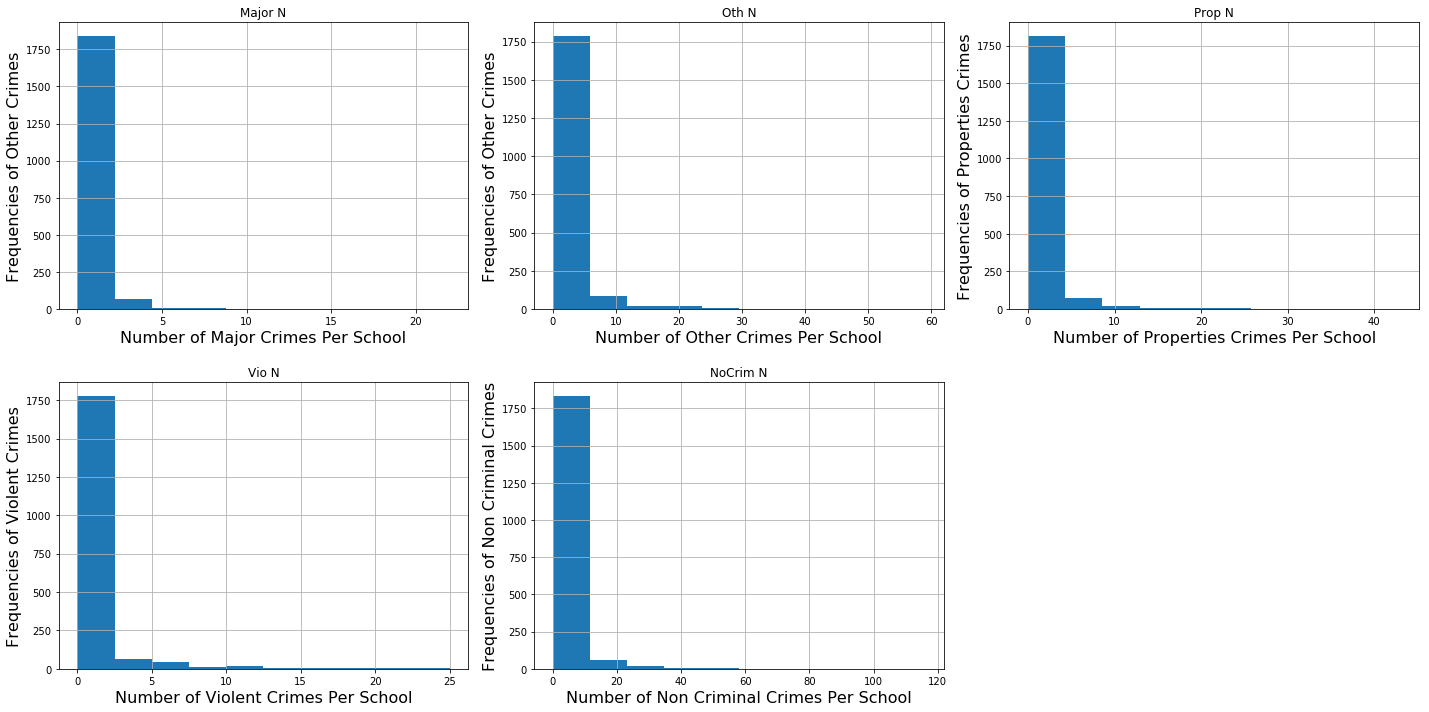

In [21]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(231)
crimeschools.groupby('DBN').sum()[['Major N']].hist(ax=ax)
ax.set_xlabel("Number of Major Crimes Per School", fontsize=16)
ax.set_ylabel("Frequencies of Other Crimes",fontsize=16)

ax = fig.add_subplot(232)
crimeschools.groupby('DBN').sum()[['Oth N']].hist(ax=ax)
ax.set_xlabel("Number of Other Crimes Per School",fontsize=16)
ax.set_ylabel("Frequencies of Other Crimes",fontsize=16)

ax = fig.add_subplot(233)
crimeschools.groupby('DBN').sum()[['Prop N']].hist(ax=ax)
ax.set_xlabel("Number of Properties Crimes Per School",fontsize=16)
ax.set_ylabel("Frequencies of Properties Crimes",fontsize=16)

ax = fig.add_subplot(234)
crimeschools.groupby('DBN').sum()[['Vio N']].hist(ax=ax)
ax.set_xlabel("Number of Violent Crimes Per School",fontsize=16)
ax.set_ylabel("Frequencies of Violent Crimes",fontsize=16)

ax = fig.add_subplot(235)
crimeschools.groupby('DBN').sum()[['NoCrim N']].hist(ax=ax)
ax.set_xlabel("Number of Non Criminal Crimes Per School",fontsize=16)
ax.set_ylabel("Frequencies of Non Criminal Crimes",fontsize=16)

plt.tight_layout()
plt.show()

**Caption: The distribution of those five kinds of crimes are nearly the same: seriously left skew. Most of the schools have only 2 major crimes, 5 other crimes, 8 property crimes, 2 violent crimes and 10 non criminal crimes.**

### Plot the distribution of "Average number of Major" crimes by school

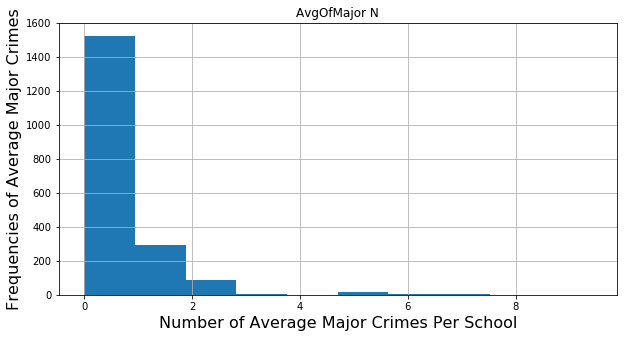

In [22]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
crimeschools.groupby("DBN").sum()[["AvgOfMajor N"]].hist(ax=ax)
ax.set_xlabel("Number of Average Major Crimes Per School", fontsize=16)
ax.set_ylabel("Frequencies of Average Major Crimes",fontsize=16)

**Caption: Same left skew distribution as above. The average major crimes in most of the school is less than 1. **

# 2. Merge school crime and SAT data 

## 2.1 Merge the SAT and the crime in school data based on the school identifier. 

In [23]:
print("crime schools DF shape", crimeschools.shape, "SAT schools DF shape", sat.shape)

crime schools DF shape (6310, 13) SAT schools DF shape (478, 3)


In [24]:
schools=sat.merge(crimeschools, on="DBN")
schools = schools[(schools.Longitude > 0 ) | (schools.Latitude > 0 ) ]
schools = schools.drop_duplicates()

In [25]:
schools.shape

(717, 15)

In [221]:
print("we lost {:.1f} percent of the data ({:d} crime in schools) in the merge".format(
    (crimeschools.shape[0] - schools.shape[0]) / crimeschools.shape[0] * 100, 
    crimeschools.shape[0] - schools.shape[0]))

we lost 89.7 percent of the data (5662 crime in schools) in the merge


**Comment: This might because the inner merge only keeps the common rows in both dataset.**

## 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course. 

In [28]:
schools = schools.fillna(value=0)

In [29]:
schools = schools[(schools.SATmath > 0 ) * (schools.SATall > 0 )]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [30]:
schools.to_csv("schoolsDF.csv", index=False)

In [31]:
schools.columns

Index(['DBN', 'SATmath', 'SATall', 'Major N', 'Oth N', 'Prop N', 'Vio N',
       'NoCrim N', 'AvgOfNoCrim N', 'AvgOfMajor N', 'AvgOfOth N',
       'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude'],
      dtype='object')

In [32]:
schools.shape

(648, 15)

## 2.3 Count the individual school location: there may be multiple schools in a single building. What could be the implication of this in your analysis? 

In [33]:
location = schools.groupby(["Longitude","Latitude"]).count()

In [ ]:
location

In [35]:
location.shape

(258, 13)

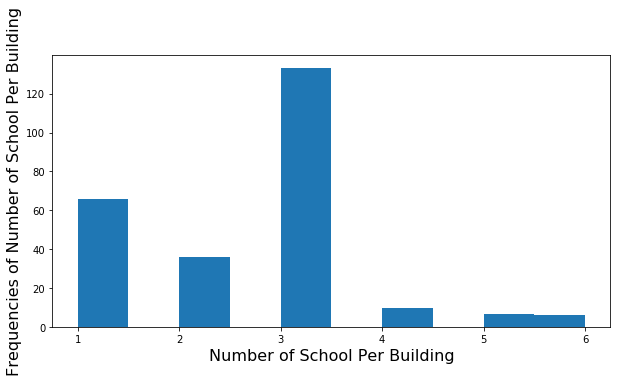

In [36]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.hist(location.DBN)
ax.set_xlabel("Number of School Per Building", fontsize=16)
ax.set_ylabel("Frequencies of Number of School Per Building",fontsize=16)

**Comment: Most of building has 3 schools, which very least number buildings has 5 to 6 schools in it.**

# 3. Visualize the school related data 

## 3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics 

In [37]:
schools.head()

,DBN,SATmath,SATall,Major N,Oth N,Prop N,Vio N,NoCrim N,AvgOfNoCrim N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,01M292,404,374.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.713684,-73.986336
3,01M448,423,390.666667,1.0,0.0,1.0,0.0,2.0,1.09,0.35,1.06,0.73,0.50,40.712399,-73.984497
4,01M448,423,390.666667,0.0,1.0,1.0,0.0,2.0,1.38,0.27,1.11,0.80,0.48,40.712399,-73.984497
5,01M448,423,390.666667,0.0,3.0,0.0,1.0,5.0,1.67,0.27,0.90,0.63,0.44,40.712399,-73.984497
6,01M450,402,383.000000,1.0,4.0,3.0,1.0,0.0,1.76,0.33,1.32,0.83,0.59,40.729589,-73.982555


### number of major crimes

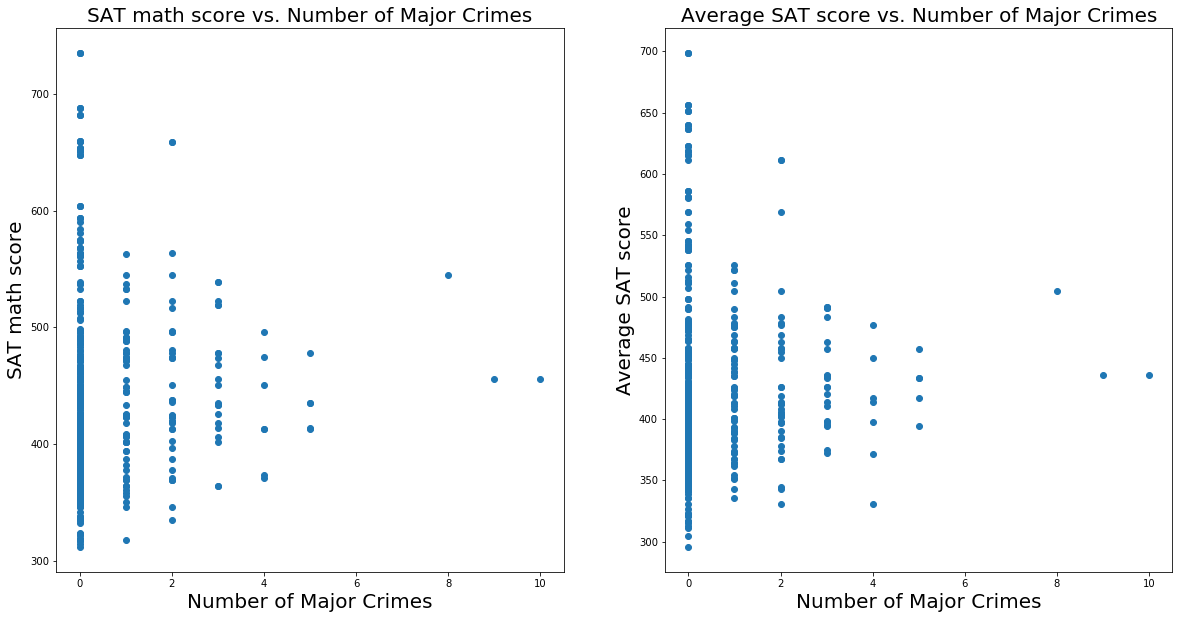

In [38]:
fig = pl.figure(figsize=(20,10)) 
ax = fig.add_subplot(121)
scatter = ax.scatter(schools['Major N'], schools['SATmath'])
ax.set_xlabel("Number of Major Crimes", fontsize=20)
ax.set_ylabel("SAT math score",fontsize=20)
ax.set_title("SAT math score vs. Number of Major Crimes",fontsize=20)

ax = fig.add_subplot(122)
scatter = ax.scatter(schools['Major N'], schools['SATall'])
ax.set_xlabel("Number of Major Crimes",fontsize=20)
ax.set_ylabel("Average SAT score",fontsize=20)
ax.set_title("Average SAT score vs. Number of Major Crimes",fontsize=20)

**Caption: from the above scatter plots, looks like the number of major crimes is not correlated with SAT scores, no matter math score or overall average score.**

### the average number of crimes

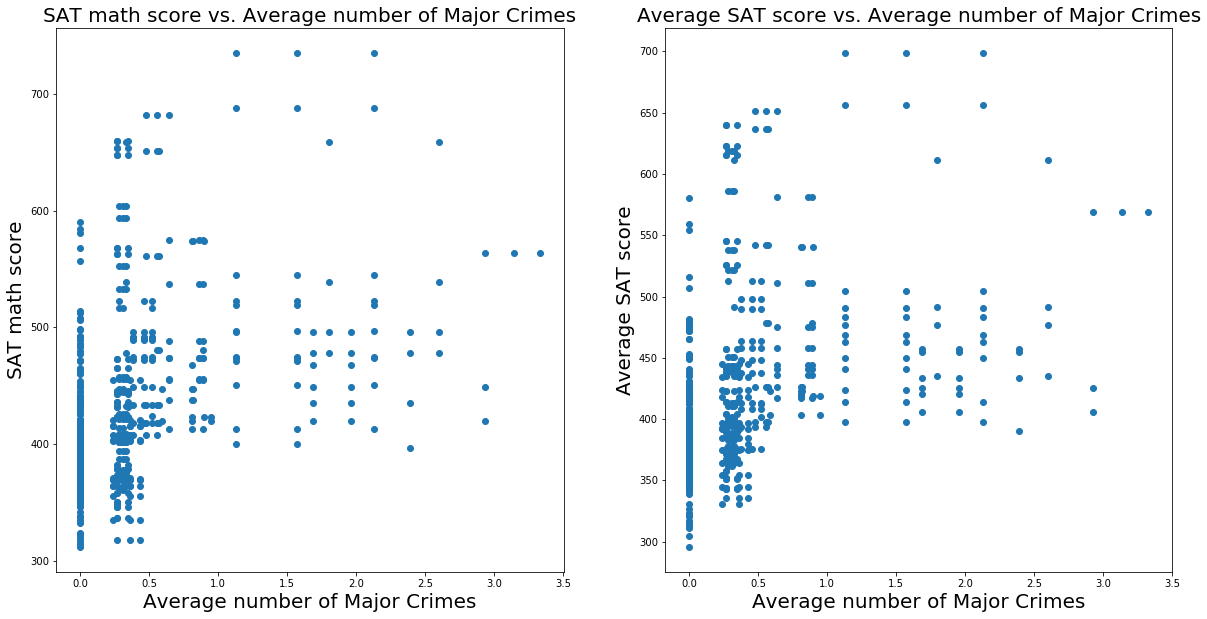

In [39]:
fig = pl.figure(figsize=(20,10)) 
ax = fig.add_subplot(121)
scatter = ax.scatter(schools['AvgOfMajor N'], schools['SATmath'])
ax.set_xlabel("Average number of Major Crimes", fontsize=20)
ax.set_ylabel("SAT math score",fontsize=20)
ax.set_title("SAT math score vs. Average number of Major Crimes",fontsize=20)

ax = fig.add_subplot(122)
scatter = ax.scatter(schools['AvgOfMajor N'], schools['SATall'])
ax.set_xlabel("Average number of Major Crimes",fontsize=20)
ax.set_ylabel("Average SAT score",fontsize=20)
ax.set_title("Average SAT score vs. Average number of Major Crimes",fontsize=20)

**Caption: from the above scatter plots, looks like the average number of major crimes is not correlated with SAT scores, no matter math score or overall average score.**

## 3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset

In [40]:
schools['lonlat'] = list(zip(schools.Longitude, schools.Latitude))
schools['geometry'] = schools[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
schools = gp.GeoDataFrame(schools)
schools.crs = from_epsg(4326)
schools.to_crs(epsg=2263, inplace=True)

In [41]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7fd9ff9b7400>)

In [42]:
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /nfshome/pl1840/PUIdata/geo_export_42083c21-c998-49c9-8535-9de35b251994.dbf  
  inflating: /nfshome/pl1840/PUIdata/geo_export_42083c21-c998-49c9-8535-9de35b251994.shp  
  inflating: /nfshome/pl1840/PUIdata/geo_export_42083c21-c998-49c9-8535-9de35b251994.shx  
  inflating: /nfshome/pl1840/PUIdata/geo_export_42083c21-c998-49c9-8535-9de35b251994.prj  


In [43]:
boro = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_de1ae3c9-6c8c-48ac-a30a-a1a106128351.shp")

In [44]:
boro.to_crs(epsg=2263, inplace=True)

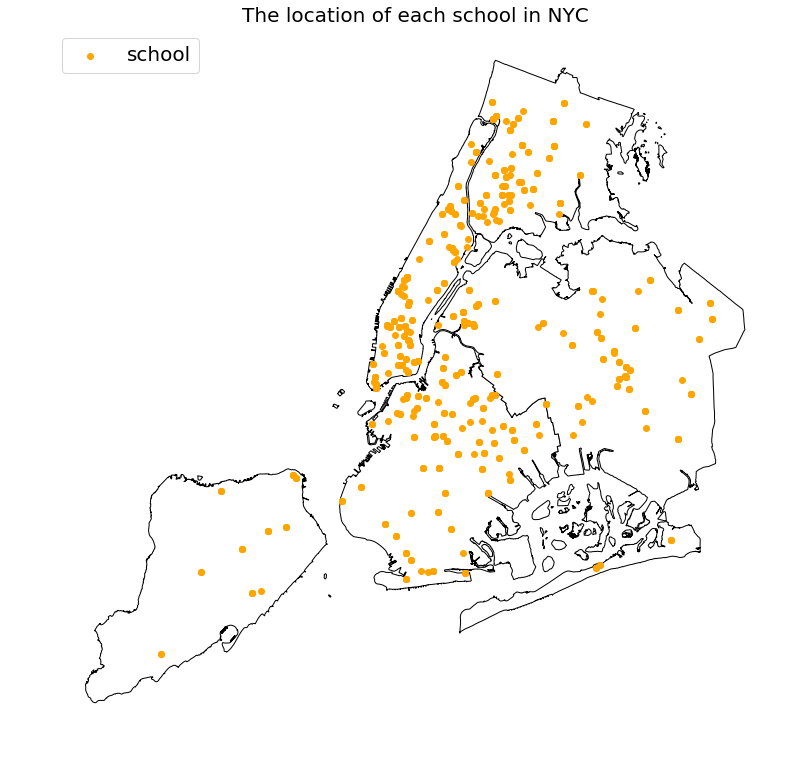

In [45]:
fig = pl.figure(figsize=(13,13)) 
ax = fig.add_subplot(111)
boro.plot(facecolor="w", edgecolor="k",ax=ax)
schools.plot(ax=ax,color="orange", label="school")
ax.set_title("The location of each school in NYC", fontsize=20)
ax.axis('off')
plt.legend(fontsize=20, loc="upper left")

**Caption: The distribution of schools in NYC seems concentrate on Manhattan, Staten Island has the least number of schools in NYC.**

# 4 Gather Asthma and drugs hospital discharge 

## 4.1 read in the SPARCS data 

In [46]:
#url = "https://health.data.ny.gov/download/3m9u-ws8e/application%2Fzip"
#urllib.request.urlretrieve(url, "file.gz")
#!unzip -d $PUIDATA file.gz

In [47]:
nd = pd.read_csv(os.getenv("PUIDATA") + "/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
nd.shape

(2544543, 38)

In [49]:
nd.head()

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"5,511.95","5,582.49",1.012798
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"4,783.20","5,162.82",1.079365
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"3,829.15","4,056.52",1.059379
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,182357.0,NaN,NaN,0,N,Y,"1,108.20","1,644.75",1.484167
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,90301264.0,NaN,NaN,0,N,Y,"3,418.18","3,370.87",0.986161


In [50]:
nd = nd[(nd['Hospital County'] == 'Kings') | (nd['Hospital County'] == 'Queens') |(nd['Hospital County'] == 'Richmond')
  |(nd['Hospital County'] == 'Manhattan') |(nd['Hospital County'] == 'Bronx')] 

In [51]:
nd.shape

(1199520, 38)

In [52]:
ndd = nd.groupby('Permanent Facility Id').count()['CCS Diagnosis Description'].reset_index()

In [53]:
print("number of NYC discharges", nd.shape[0])

number of NYC discharges 1199520


In [54]:
nycF = nd['Permanent Facility Id'].nunique()
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset 61


In [55]:
nd.columns

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code',
       'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs',
       'Ratio of Total Costs to Tota

In [56]:
nd = nd[(nd['CCS Diagnosis Description']=='Asthma') |
        (nd['CCS Diagnosis Description']=='Respiratory failure; insufficiency; arrest (adult)')|
       (nd['CCS Diagnosis Description']=='Respiratory distress syndrome')|
        (nd['CCS Diagnosis Description']=='Poisoning by psychotropic agents')|
       (nd['CCS Diagnosis Description']=='Alcohol-related disorders')|
        (nd['CCS Diagnosis Description']=='Substance-related disorders')]

In [57]:
nd.shape

(77053, 38)

In [58]:
nd.head()

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
973820,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,30 to 49,104,M,Black/African American,Not Span/Hispanic,...,NaN,232661.0,232661.0,NaN,0,N,N,"16,533.18","10,561.96",0.638834
973828,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,232661.0,232661.0,NaN,0,N,N,"16,646.22","10,696.09",0.642554
973835,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,F,Other Race,Unknown,...,NaN,232661.0,232661.0,NaN,0,N,N,"14,566.72","9,499.08",0.652108
973836,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,30 to 49,104,M,Other Race,Unknown,...,NaN,232661.0,232661.0,NaN,0,N,N,"13,201.68","8,567.19",0.648947
973840,New York City,Bronx,7000001.0,1164.0,Bronx-Lebanon Hospital Center - Fulton Division,50 to 69,104,M,Other Race,Unknown,...,NaN,232661.0,232661.0,NaN,0,N,N,"12,637.48","8,486.26",0.671515


In [59]:
nyca = nd[(nd['CCS Diagnosis Description']=='Asthma')\
    + (nd['CCS Diagnosis Description']=='Respiratory failure; insufficiency; arrest (adult)')\
    + (nd['CCS Diagnosis Description']=='Respiratory distress syndrome')]
nyca.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(30717, 38)

In [60]:
print("number of asthma related cases in NYC", nyca.shape[0])

number of asthma related cases in NYC 30717


In [61]:
nycd = nd[(nd['CCS Diagnosis Description']=='Poisoning by psychotropic agents')\
    + (nd['CCS Diagnosis Description']=='Alcohol-related disorders')\
    + (nd['CCS Diagnosis Description']=='Substance-related disorders')]
nycd.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(46336, 38)

In [62]:
print("number of drug related cases in NYC", nycd.shape[0])

number of drug related cases in NYC 46336


## 4.2 calculate the fraction of asthma and drug related diagnoses per facility 

In [63]:
aa = nyca.groupby('Permanent Facility Id').count()['CCS Diagnosis Description'].reset_index()

In [64]:
dd = nycd.groupby('Permanent Facility Id').count()['CCS Diagnosis Description'].reset_index()

In [65]:
ad = pd.merge(aa,dd, on="Permanent Facility Id")

In [66]:
ad = ad.merge(ndd, on="Permanent Facility Id")

In [67]:
print("we lost {:.1f} per cent of the data ({:d} facilities) in the merge".format(
    (ad.shape[0] - ndd.shape[0]) / ad.shape[0] * 100, 
    ad.shape[0] - ndd.shape[0]))

we lost -17.3 per cent of the data (-9 facilities) in the merge


In [68]:
ad.rename(columns={"CCS Diagnosis Description_x":"asthma","CCS Diagnosis Description_y":"drug"}, inplace=True)

In [69]:
ad.rename(columns={"CCS Diagnosis Description":"total"},inplace=True)

In [70]:
ad.head()

,Permanent Facility Id,asthma,drug,total
0,1165.0,1123,1279,20956
1,1168.0,580,1006,15889
2,1169.0,2105,323,43650
3,1172.0,1826,611,23142
4,1176.0,910,4177,20585


In [71]:
ad['asthmaRatio'] = ad['asthma']/ad['total']
ad['drugsRatio'] = ad['drug']/ad['total']

In [72]:
ad.head()

,Permanent Facility Id,asthma,drug,total,asthmaRatio,drugsRatio
0,1165.0,1123,1279,20956,0.053588,0.061033
1,1168.0,580,1006,15889,0.036503,0.063314
2,1169.0,2105,323,43650,0.048225,0.007400
3,1172.0,1826,611,23142,0.078904,0.026402
4,1176.0,910,4177,20585,0.044207,0.202915


In [73]:
discharge = ad[['Permanent Facility Id','asthmaRatio','drugsRatio']]
discharge.head()

,Permanent Facility Id,asthmaRatio,drugsRatio
0,1165.0,0.053588,0.061033
1,1168.0,0.036503,0.063314
2,1169.0,0.048225,0.007400
3,1172.0,0.078904,0.026402
4,1176.0,0.044207,0.202915


In [74]:
discharge.shape

(52, 3)

## 4.3 find the location of each facility 

In [75]:
try:
    import urllib2 as ulib
except ImportError:
    import urllib as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

import ast
import pandas as pd

API_URL = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCartoDB(query, formatting = 'CSV', source = API_URL):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [76]:
test = '''
SELECT *
FROM fb55.nyc_facilities
'''

In [77]:
nyc_facilities=pd.read_csv(io(queryCartoDB(test)), sep=',')
nyc_facilities.head()

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"


In [78]:
nyc_facilities=nyc_facilities[['facility_longitude','facility_latitude','facility_id']]

In [79]:
nyc_facilities.rename(columns={"facility_id":"Permanent Facility Id"},inplace=True)

In [80]:
nyc_facilities.head()

,facility_longitude,facility_latitude,Permanent Facility Id
0,-73.945045,40.654518,1320
1,-73.886772,40.653175,6448
2,-73.956383,40.689243,6754
3,-73.904655,40.846165,1206
4,-73.919029,40.814503,1207


In [81]:
asmaDrugsData =pd.merge(nyc_facilities,discharge,on="Permanent Facility Id")

In [82]:
asmaDrugsData.drop('Permanent Facility Id',axis=1, inplace=True)

In [83]:
asmaDrugsData.head()

,facility_longitude,facility_latitude,asthmaRatio,drugsRatio
0,-73.945045,40.654518,0.033731,0.007030
1,-73.940506,40.814350,0.044740,0.098310
2,-73.937515,40.677940,0.039595,0.154344
3,-73.846741,40.857388,0.053588,0.061033
4,-73.861420,40.894569,0.036503,0.063314


In [84]:
asmaDrugsData.shape

(49, 4)

In [85]:
print("we lost {:.1f} per cent of the data ({:d} facilities) in the merge".format(
    (discharge.shape[0] - asmaDrugsData.shape[0]) / discharge.shape[0] * 100, 
    discharge.shape[0] - asmaDrugsData.shape[0]))

we lost 5.8 per cent of the data (3 facilities) in the merge


**Comment: There are 49 facilities left after the merge. The reason might be inner merge will only keep the common rows in both dataframe, which means there are 3 facilities in discharge data does not have location information in nyc_failities dataset. Or, in nyc_facilities dataset, some of the locations only ratio information, either asthma or drugs.**

# 5. Aggregate at the PUMA level 

## 5.1 getting PUMA geodata 

In [86]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /nfshome/pl1840/PUIdata/geo_export_c9316dc2-99f1-4728-b0e6-f41dd0552deb.dbf  
  inflating: /nfshome/pl1840/PUIdata/geo_export_c9316dc2-99f1-4728-b0e6-f41dd0552deb.shp  
  inflating: /nfshome/pl1840/PUIdata/geo_export_c9316dc2-99f1-4728-b0e6-f41dd0552deb.shx  
  inflating: /nfshome/pl1840/PUIdata/geo_export_c9316dc2-99f1-4728-b0e6-f41dd0552deb.prj  


In [87]:
puma = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + 
                                     "geo_export_a2bf0126-c637-4c22-939b-af723de6e9f0.shp")

In [88]:
puma.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [89]:
facilities = asmaDrugsData

In [90]:
facilities['lonlat'] = list(zip(facilities.facility_longitude, facilities.facility_latitude))
facilities['geometry'] = facilities[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
facilities = gp.GeoDataFrame(facilities)
facilities.crs = from_epsg(4326)
facilities.to_crs(epsg=2263, inplace=True)

In [91]:
puma.to_crs(epsg=2263, inplace=True)

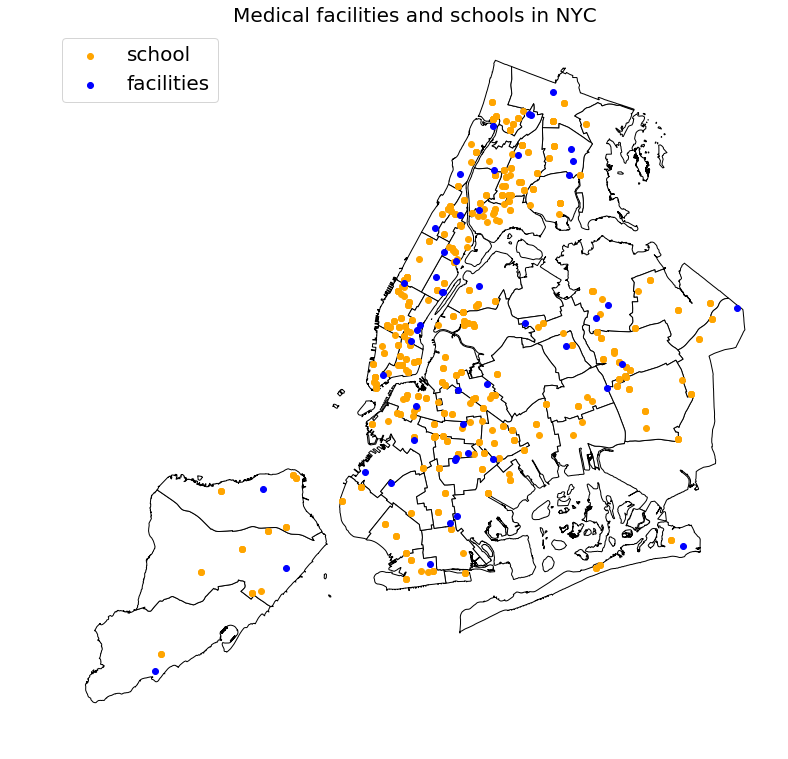

In [92]:
fig = pl.figure(figsize=(13,13)) 
ax = fig.add_subplot(111)
puma.plot(facecolor="w", edgecolor="k",ax=ax)
schools.plot(ax=ax,color="orange", label="school")
facilities.plot(ax=ax, color="blue", label="facilities")
ax.set_title("Medical facilities and schools in NYC", fontsize=20)
ax.axis('off')
plt.legend(fontsize=20, loc="upper left")

**Caption: The number of schools in NYC is obviously more than the number of medical facilities in NYC. Also, Manhattan has the most dense distribution, and Staten Island has the most sparse distributionl.**

## 5.2 join hospital facilities and PUMA data 

In [93]:
pumafa = gp.sjoin(puma, facilities, op="contains")
pumafa.head()

,puma,shape_area,shape_leng,geometry,index_right,facility_longitude,facility_latitude,asthmaRatio,drugsRatio,lonlat
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",4,-73.861420,40.894569,0.036503,0.063314,"(-73.86142, 40.894569)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3,-73.846741,40.857388,0.053588,0.061033,"(-73.84674100000001, 40.857388)"
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",46,-73.845055,40.849575,0.020517,0.003506,"(-73.845055, 40.849575)"
5,4016,1.207135e+08,109477.751817,"POLYGON ((999782.7833862281 162246.8424071733,...",12,-73.948967,40.613419,0.029730,0.007400,"(-73.94896700000001, 40.613419)"
6,3705,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",7,-73.891014,40.853909,0.044207,0.202915,"(-73.891014, 40.853909)"


In [94]:
pumafa = pumafa[['puma', 'asthmaRatio', 'drugsRatio']]
pumafa.head()

,puma,asthmaRatio,drugsRatio
1,3702,0.036503,0.063314
3,3704,0.053588,0.061033
3,3704,0.020517,0.003506
5,4016,0.029730,0.007400
6,3705,0.044207,0.202915


## 5.3 join school data and puma 

In [95]:
pumaschool = gp.sjoin(puma, schools, op="contains")
pumaschool.head()

,puma,shape_area,shape_leng,geometry,index_right,DBN,SATmath,SATall,Major N,Oth N,...,Vio N,NoCrim N,AvgOfNoCrim N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,lonlat
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",567,10X442,420,423.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.870293,-73.898309,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",537,10X342,333,311.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.870293,-73.898309,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",528,10X268,356,320.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.870293,-73.898309,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",580,10X549,379,371.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.870293,-73.898309,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",549,10X433,371,368.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.870293,-73.898309,"(-73.898309, 40.870293)"


In [96]:
pumaschool.columns

Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'index_right', 'DBN',
       'SATmath', 'SATall', 'Major N', 'Oth N', 'Prop N', 'Vio N', 'NoCrim N',
       'AvgOfNoCrim N', 'AvgOfMajor N', 'AvgOfOth N', 'AvgOfProp N',
       'AvgOfVio N', 'Latitude', 'Longitude', 'lonlat'],
      dtype='object')

In [97]:
pumaschool = pumaschool[['puma', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'SATmath', 'SATall' ]]
pumaschool.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall
0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,420,423.333333
0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333,311.333333
0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356,320.666667
0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,379,371.666667
0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,371,368.666667


In [98]:
type(pumaschool)

pandas.core.frame.DataFrame

In [99]:
pumaschool.shape

(648, 13)

In [100]:
alldata = pd.merge(pumaschool, pumafa, on="puma", how="outer")

In [101]:
alldata = alldata.groupby("puma").mean().reset_index()
alldata.shape

(54, 15)

In [102]:
alldata.dropna(inplace=True)
alldata.shape

(36, 15)

In [103]:
alldata.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314
3,3704,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000,0.037053,0.032269
4,3705,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559,0.044207,0.202915
6,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.054454,0.013583
8,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.057007,0.003671


# PART II Visual and Exploratory analysis and Modeling

# 6. Checking collinearity and covariance of the data

## 6.1 Plot SAT features against each other and assess collinearity 

In [104]:
satdf = satdf[['SAT Critical Reading Avg. Score','SATmath','SAT Writing Avg. Score']]
satdf.rename(columns={"SAT Writing Avg. Score":"SATwriting","SAT Critical Reading Avg. Score":"SATreading"},inplace=True)

In [105]:
satdf.head()

,SATreading,SATmath,SATwriting
0,355,404,363
1,383,423,366
2,377,402,370
3,414,401,359
4,390,433,384


In [106]:
satdf = satdf[(satdf.SATmath > 0 ) * (satdf.SATreading > 0 ) * (satdf.SATwriting > 0)]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


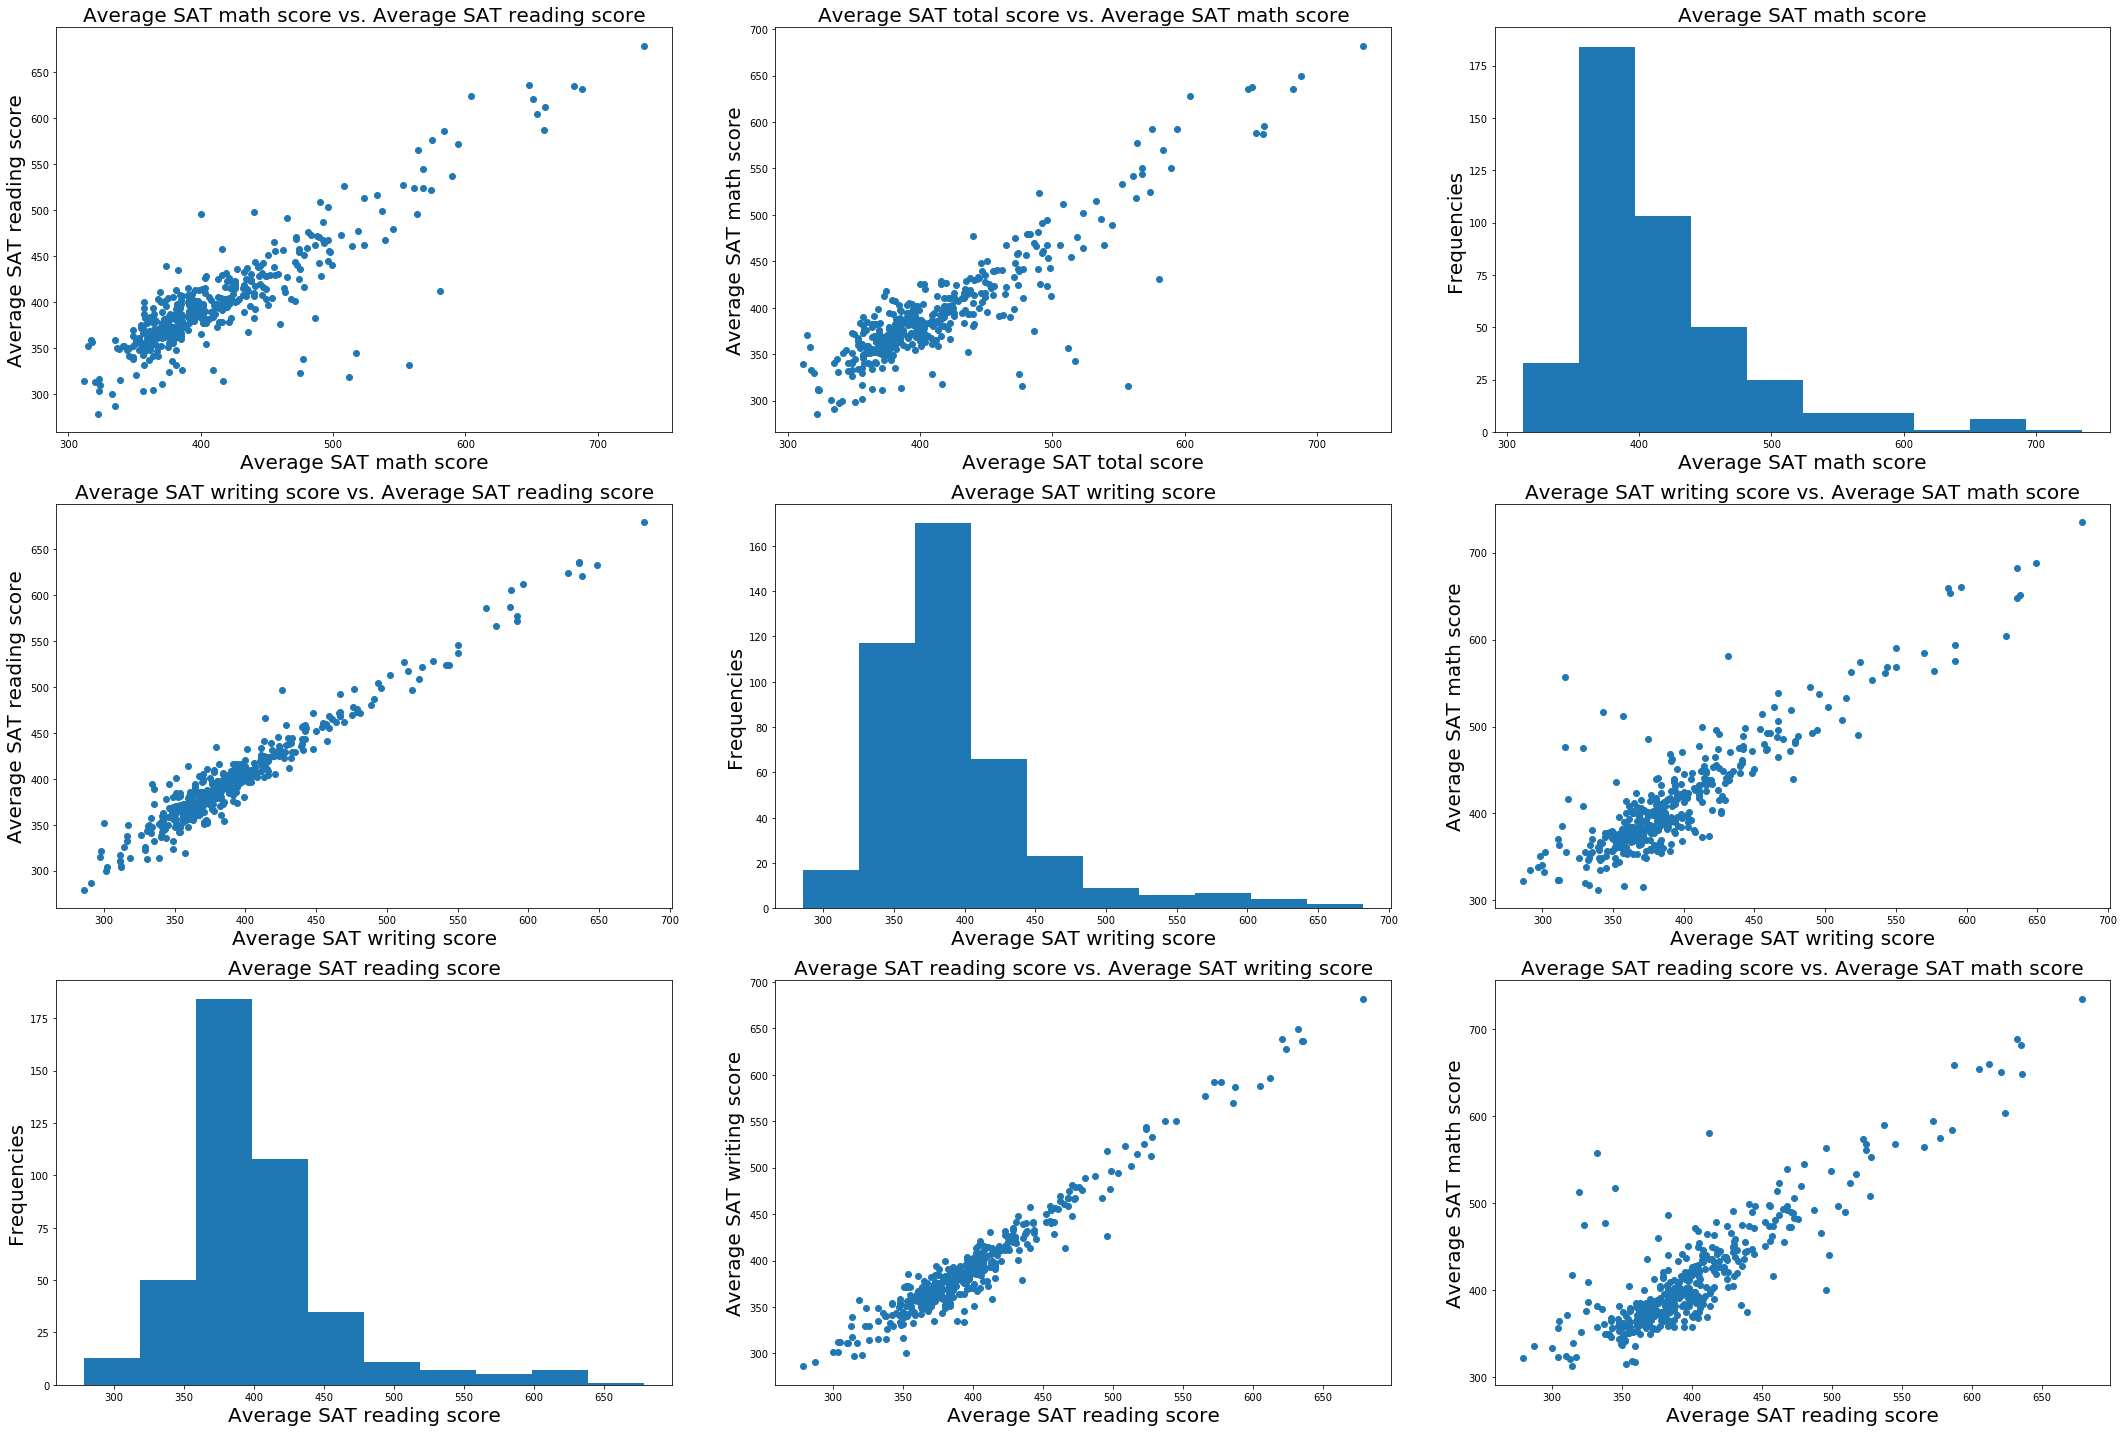

In [107]:
fig = pl.figure(figsize=(30,20)) 
ax = fig.add_subplot(331)
scatter = ax.scatter(satdf['SATmath'], satdf['SATreading'])
ax.set_xlabel("Average SAT math score", fontsize=20)
ax.set_ylabel("Average SAT reading score",fontsize=20)
ax.set_title("Average SAT math score vs. Average SAT reading score",fontsize=20)

ax = fig.add_subplot(332)
scatter = ax.scatter(satdf['SATmath'], satdf['SATwriting'])
ax.set_xlabel("Average SAT total score",fontsize=20)
ax.set_ylabel("Average SAT math score",fontsize=20)
ax.set_title("Average SAT total score vs. Average SAT math score",fontsize=20)

ax = fig.add_subplot(333)
plt.hist(satdf['SATmath'])
ax.set_xlabel("Average SAT math score", fontsize=20)
ax.set_ylabel("Frequencies",fontsize=20)
ax.set_title("Average SAT math score",fontsize=20)

ax = fig.add_subplot(334)
scatter = ax.scatter(satdf['SATwriting'], satdf['SATreading'])
ax.set_xlabel("Average SAT writing score", fontsize=20)
ax.set_ylabel("Average SAT reading score",fontsize=20)
ax.set_title("Average SAT writing score vs. Average SAT reading score",fontsize=20)

ax = fig.add_subplot(335)
plt.hist(satdf['SATwriting'])
ax.set_xlabel("Average SAT writing score", fontsize=20)
ax.set_ylabel("Frequencies",fontsize=20)
ax.set_title("Average SAT writing score",fontsize=20)

ax = fig.add_subplot(336)
scatter = ax.scatter(satdf['SATwriting'], satdf['SATmath'])
ax.set_xlabel("Average SAT writing score", fontsize=20)
ax.set_ylabel("Average SAT math score",fontsize=20)
ax.set_title("Average SAT writing score vs. Average SAT math score",fontsize=20)

ax = fig.add_subplot(337)
plt.hist(satdf['SATreading'])
ax.set_xlabel("Average SAT reading score", fontsize=20)
ax.set_ylabel("Frequencies",fontsize=20)
ax.set_title("Average SAT reading score",fontsize=20)

ax = fig.add_subplot(338)
scatter = ax.scatter(satdf['SATreading'], satdf['SATwriting'])
ax.set_xlabel("Average SAT reading score", fontsize=20)
ax.set_ylabel("Average SAT writing score",fontsize=20)
ax.set_title("Average SAT reading score vs. Average SAT writing score",fontsize=20)

ax = fig.add_subplot(339)
scatter = ax.scatter(satdf['SATreading'], satdf['SATmath'])
ax.set_xlabel("Average SAT reading score", fontsize=20)
ax.set_ylabel("Average SAT math score",fontsize=20)
ax.set_title("Average SAT reading score vs. Average SAT math score",fontsize=20)

plt.tight_layout()
plt.show()

**Comment: All SAT features are having collinearity against each other, while reading score and writing score have higher collinearity. The distribution of all three features are left scew.**

In [108]:
satdf.corr()

,SATreading,SATmath,SATwriting
SATreading,1.000000,0.872412,0.970342
SATmath,0.872412,1.000000,0.888456
SATwriting,0.970342,0.888456,1.000000


**Comment: the above correlation table indicates the same result from the scatter plot, writing and reading has the highest correlation which could be consider as collinearity when fitting linear model.**

## 6.2 plot the SAT feature by PUMA against 3 of the crime features 

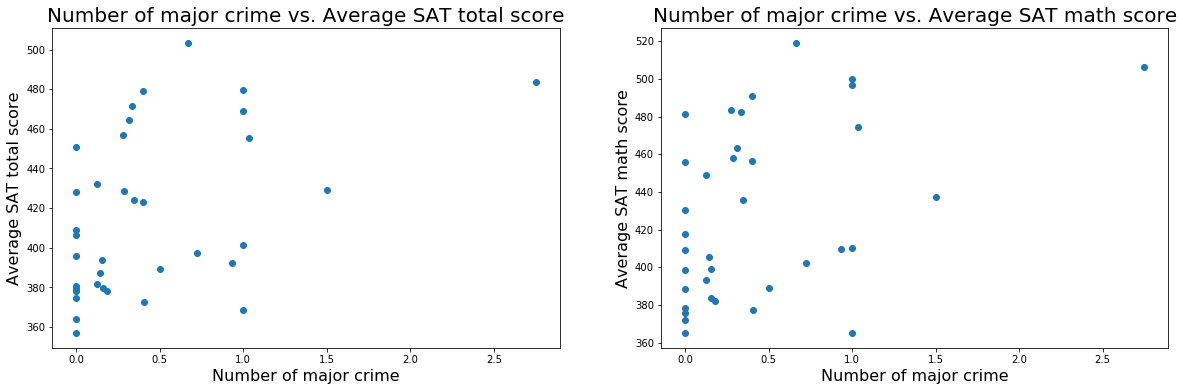

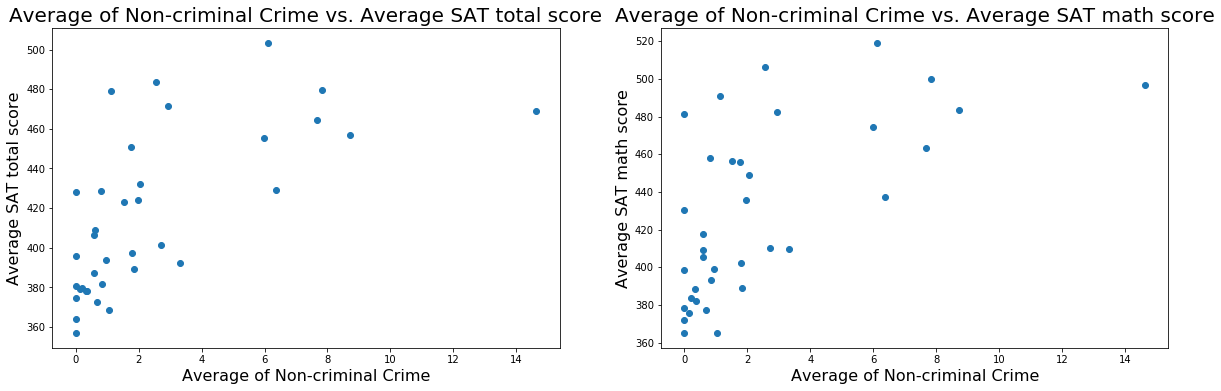

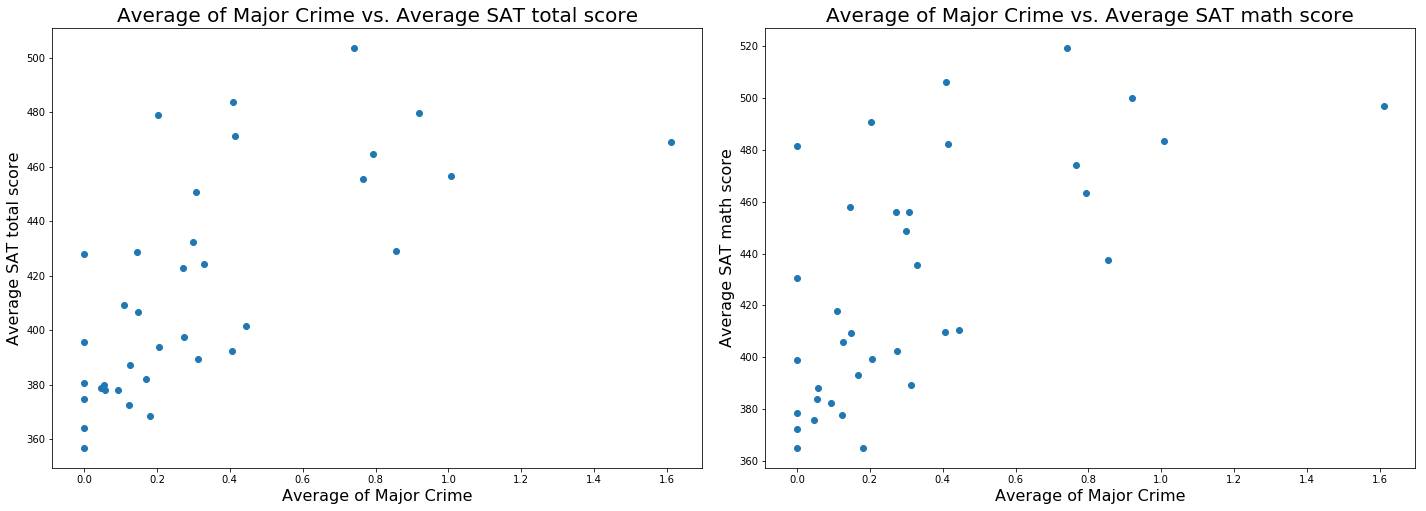

In [109]:
fig = pl.figure(figsize=(20,20)) 
ax = fig.add_subplot(321)
scatter = ax.scatter(alldata['Major N'], alldata['SATall'])
ax.set_xlabel("Number of major crime", fontsize=16)
ax.set_ylabel("Average SAT total score",fontsize=16)
ax.set_title("Number of major crime vs. Average SAT total score",fontsize=20)

ax = fig.add_subplot(322)
scatter = ax.scatter(alldata['Major N'], alldata['SATmath'])
ax.set_xlabel("Number of major crime",fontsize=16)
ax.set_ylabel("Average SAT math score",fontsize=16)
ax.set_title("Number of major crime vs. Average SAT math score",fontsize=20)

fig = pl.figure(figsize=(20,20)) 
ax = fig.add_subplot(323)
scatter = ax.scatter(alldata['AvgOfNoCrim N'], alldata['SATall'])
ax.set_xlabel("Average of Non-criminal Crime", fontsize=16)
ax.set_ylabel("Average SAT total score",fontsize=16)
ax.set_title("Average of Non-criminal Crime vs. Average SAT total score",fontsize=20)

ax = fig.add_subplot(324)
scatter = ax.scatter(alldata['AvgOfNoCrim N'], alldata['SATmath'])
ax.set_xlabel("Average of Non-criminal Crime",fontsize=16)
ax.set_ylabel("Average SAT math score",fontsize=16)
ax.set_title("Average of Non-criminal Crime vs. Average SAT math score",fontsize=20)

fig = pl.figure(figsize=(20,20)) 
ax = fig.add_subplot(325)
scatter = ax.scatter(alldata['AvgOfMajor N'], alldata['SATall'])
ax.set_xlabel("Average of Major Crime", fontsize=16)
ax.set_ylabel("Average SAT total score",fontsize=16)
ax.set_title("Average of Major Crime vs. Average SAT total score",fontsize=20)

ax = fig.add_subplot(326)
scatter = ax.scatter(alldata['AvgOfMajor N'], alldata['SATmath'])
ax.set_xlabel("Average of Major Crime",fontsize=16)
ax.set_ylabel("Average SAT math score",fontsize=16)
ax.set_title("Average of Major Crime vs. Average SAT math score",fontsize=20)

plt.tight_layout()
plt.show()

**Comment: Both SAT features by PUMA has slightly positive correlation with 3 of the crime features.**

## 6.3 plot the SAT feature against medical data 

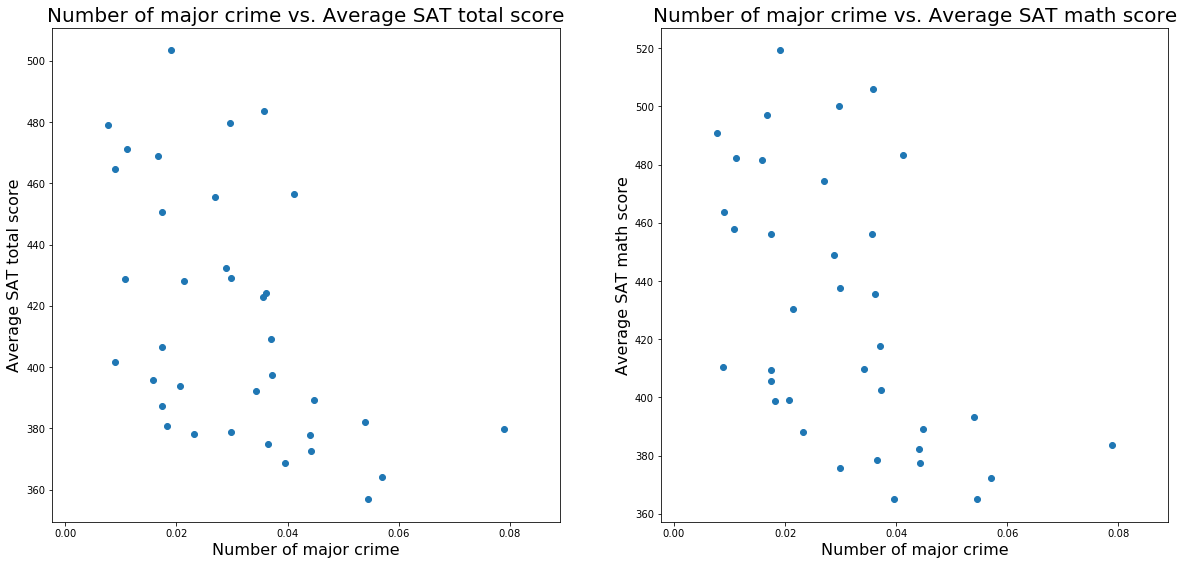

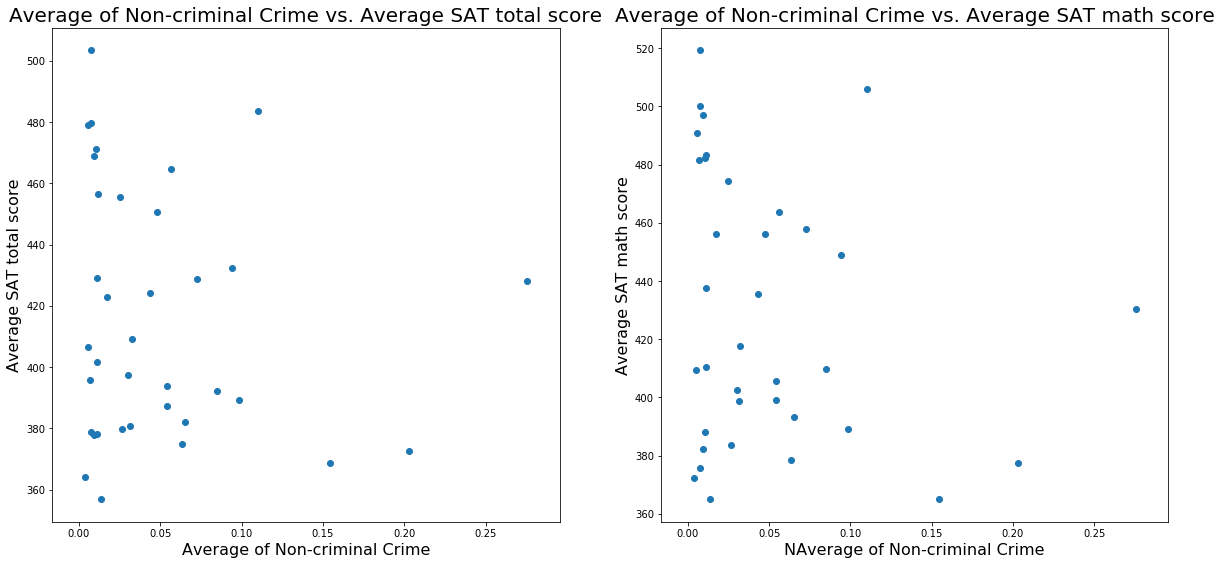

In [110]:
fig = pl.figure(figsize=(20,20)) 
ax = fig.add_subplot(221)
scatter = ax.scatter(alldata['asthmaRatio'], alldata['SATall'])
ax.set_xlabel("Number of major crime", fontsize=16)
ax.set_ylabel("Average SAT total score",fontsize=16)
ax.set_title("Number of major crime vs. Average SAT total score",fontsize=20)

ax = fig.add_subplot(222)
scatter = ax.scatter(alldata['asthmaRatio'], alldata['SATmath'])
ax.set_xlabel("Number of major crime",fontsize=16)
ax.set_ylabel("Average SAT math score",fontsize=16)
ax.set_title("Number of major crime vs. Average SAT math score",fontsize=20)

fig = pl.figure(figsize=(20,20)) 
ax = fig.add_subplot(223)
scatter = ax.scatter(alldata['drugsRatio'], alldata['SATall'])
ax.set_xlabel("Average of Non-criminal Crime", fontsize=16)
ax.set_ylabel("Average SAT total score",fontsize=16)
ax.set_title("Average of Non-criminal Crime vs. Average SAT total score",fontsize=20)

ax = fig.add_subplot(224)
scatter = ax.scatter(alldata['drugsRatio'], alldata['SATmath'])
ax.set_xlabel("NAverage of Non-criminal Crime",fontsize=16)
ax.set_ylabel("Average SAT math score",fontsize=16)
ax.set_title("Average of Non-criminal Crime vs. Average SAT math score",fontsize=20)

**Comment: The above scatter plots indicates that there are slightly negative correlation between SAT features and medical data features.**

# Plot a covariance matrix of all features

In [111]:
allcorr = alldata.corr()

In [112]:
allcorr.index

Index(['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'SATmath',
       'SATall', 'asthmaRatio', 'drugsRatio'],
      dtype='object')

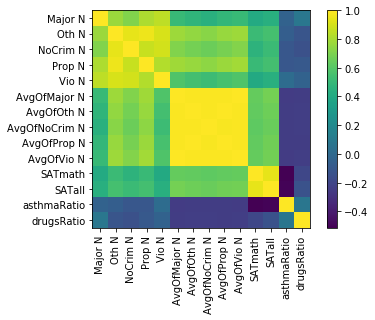

In [113]:
ax = pl.figure().add_subplot(111)
cax = ax.imshow(allcorr)
pl.colorbar(cax)
ax.set_xticks(range(len(allcorr.index)))
ax.set_xticklabels(allcorr.index, rotation=90)
ax.set_yticks(range(len(allcorr.index)))
ax.set_yticklabels(allcorr.index);

**Comment: **
- crimes in schools features are highly correlated with each other, especially the average crimes features.
- SAT features are highly correlated with each other, the correlation is very close to 1.
- medical features are not correlated with each other, the correlation of these two ratio is very small. And these features has negative correlation with SAT features and crimes features.

# 7. Mapping 

In [114]:
allshp = puma.merge(alldata, on="puma")

In [115]:
allshp.shape

(36, 18)

### the SAT features

In [116]:
import choroplethNYC as cp

(905464.73923034826, 1075092.8783844009, 112485.7606161537, 280480.41464392259)

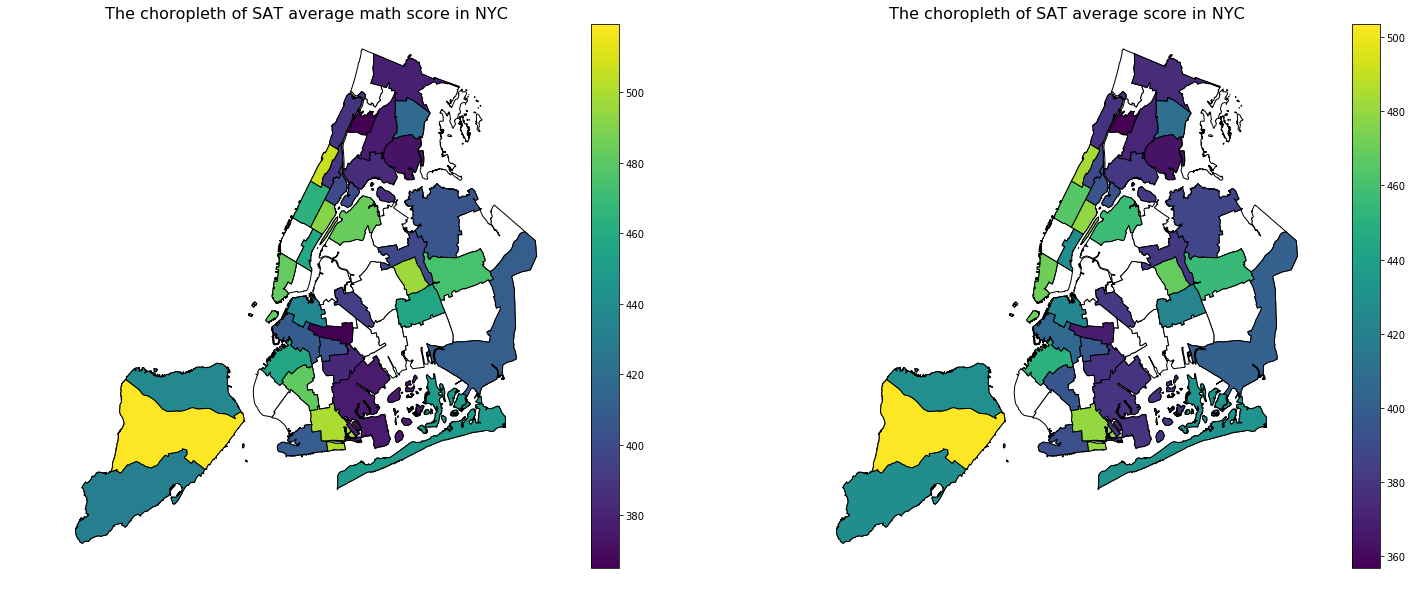

In [117]:
fig = pl.figure(figsize=(25, 10))

ax1 = fig.add_subplot(121)
puma.plot(facecolor="w", edgecolor="k",ax=ax1)
allshp.plot(column='SATmath', edgecolor='black',ax=ax1,legend=True)
ax1.set_title("The choropleth of SAT average math score in NYC", fontsize=16)
ax1.axis("off")

ax2 = fig.add_subplot(122)
puma.plot(facecolor="w", edgecolor="k",ax=ax2)
allshp.plot(column='SATall', edgecolor='black', ax=ax2,legend=True)
ax2.set_title("The choropleth of SAT average score in NYC", fontsize=16)
ax2.axis("off")

**Caption: The choropleth of SAT average math score in NYC looks exactly like the choropleth of SAT average score in NYC, except the range of legend. This is because SATmath and SATall is highly correlated, since SATall is calculated by SATmath. There are some region that don't have SAT score record in 2012. But as can be seen from the map, Staten Island has highest SAT score, brooklyn and bronx has the lowest SAT score.**

### the 3 chosen school crime features

(905464.73923034826, 1075092.8783844009, 112485.7606161537, 280480.41464392259)

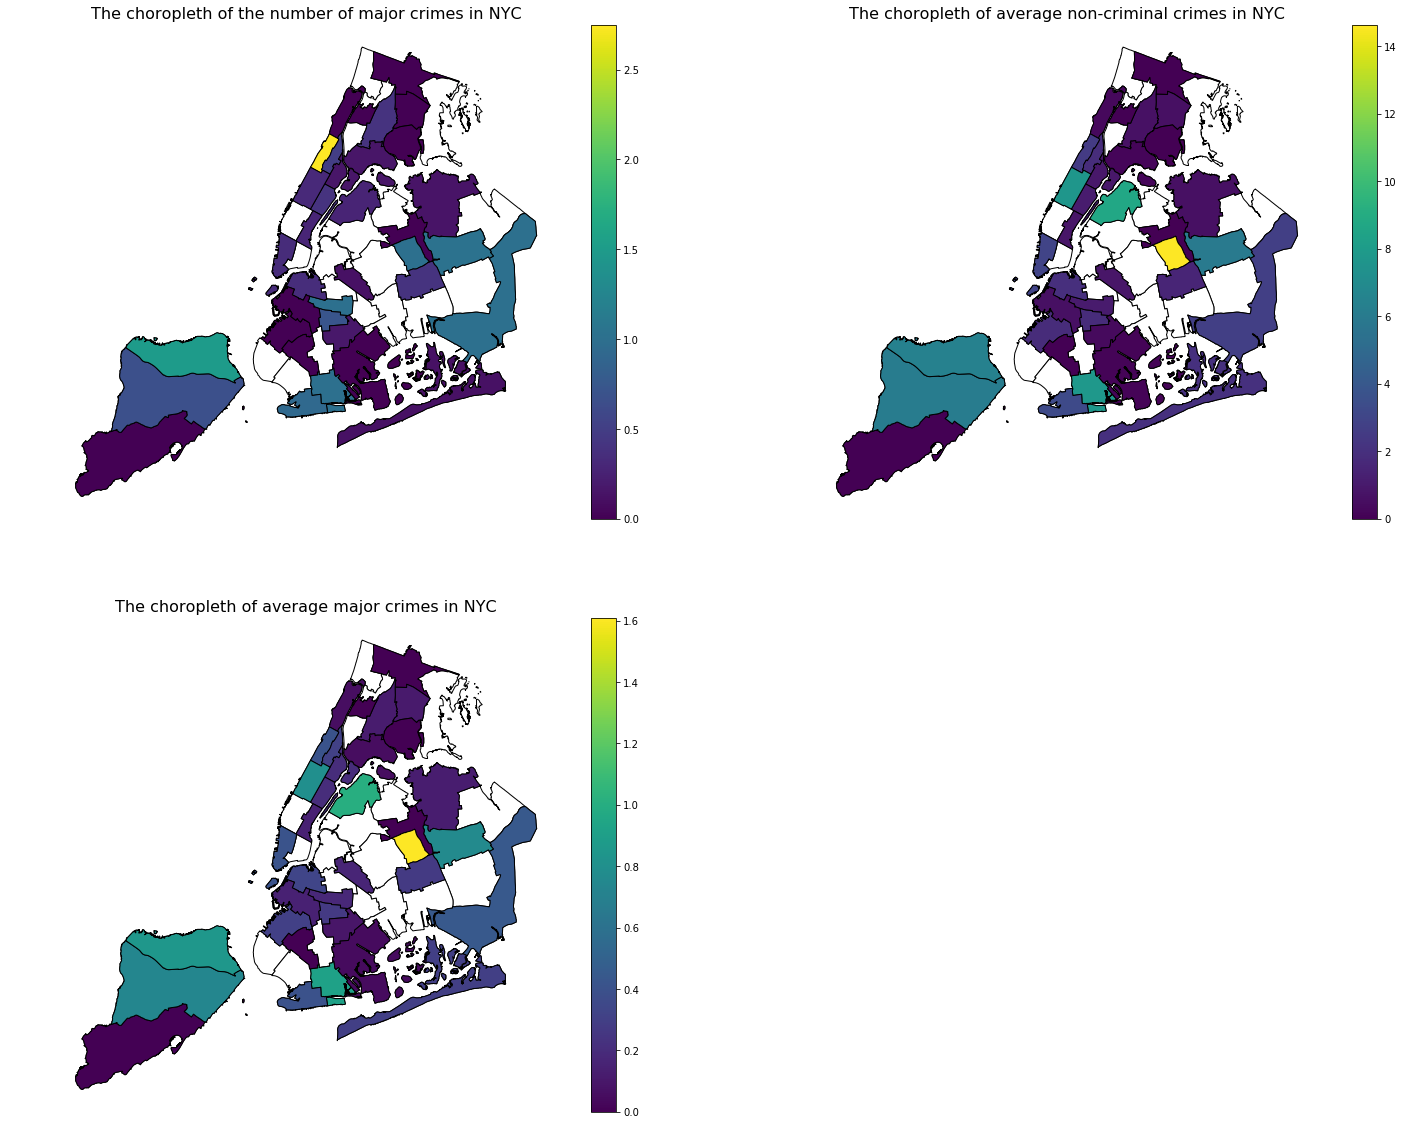

In [220]:
fig = pl.figure(figsize=(25, 20))
ax1= fig.add_subplot(221)
puma.plot(facecolor="w", edgecolor="k",ax=ax1)
allshp.plot(column='Major N', edgecolor='black',ax=ax1, legend=True)
ax1.set_title("The choropleth of the number of major crimes in NYC", fontsize=16)
ax1.axis("off")

ax2= fig.add_subplot(222)
puma.plot(facecolor="w", edgecolor="k",ax=ax2)
allshp.plot(column='AvgOfNoCrim N', edgecolor='black',ax=ax2, legend=True)
ax2.set_title("The choropleth of average non-criminal crimes in NYC", fontsize=16)
ax2.axis("off")

ax3 = fig.add_subplot(223)
puma.plot(facecolor="w", edgecolor="k",ax=ax3)
allshp.plot(column='AvgOfMajor N', edgecolor='black',ax=ax3,legend=True)
ax3.set_title("The choropleth of average major crimes in NYC", fontsize=16)
ax3.axis("off")

**Note that number of major crimes, average non-criminal crimes and average major crimes are aggregated in building location. Since the alldata dataset is group by each puma and all the features presented is the average of each puma. So in the caption, I'll just interpret the features as average per puma for simplicity.**

**Caption: **
- The choropleth of the number of major crimes in NYC indicates that upper Manhattan has the highest number of crimes in schools. Although there are certain areas I don't have corresponding data to plot, most of the area has at least one major crimes on average based on the data I have.
- The choropleth of the avaerage non-criminal crimes and the avaerage major crimes looks nearly the same, except the scale of the legend. This is because these two features are highly correlated. In both choropleths, jamaica is the area that has the most average major crimes and average non-criminal crimes. The upper part of the staten island is not safety as the lower part, in all crimes features. 

### the two medical discharge fieatures

(905464.73923034826, 1075092.8783844009, 112485.7606161537, 280480.41464392259)

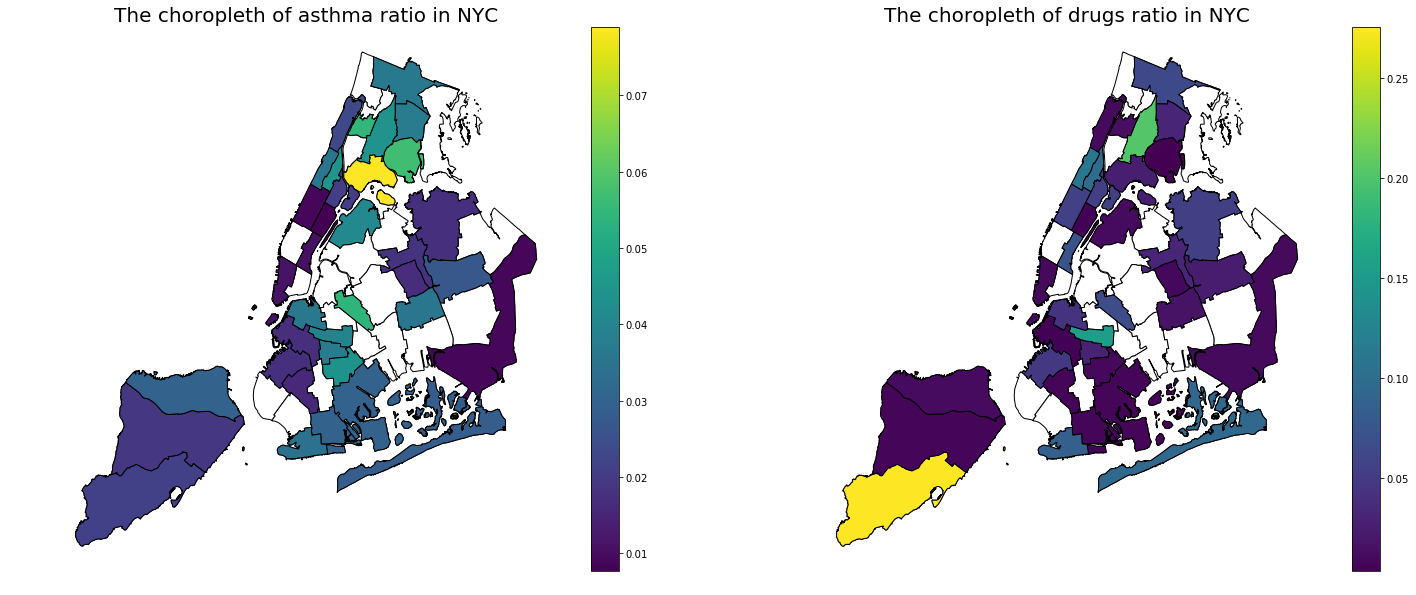

In [219]:
fig = pl.figure(figsize=(25, 10))
ax1 = fig.add_subplot(121)
puma.plot(facecolor="w", edgecolor="k",ax=ax1)
allshp.plot(column='asthmaRatio', edgecolor='black',ax=ax1,legend=True)
ax1.set_title("The choropleth of asthma ratio in NYC", fontsize=20)
ax1.axis("off")

ax2 = fig.add_subplot(122)
puma.plot(facecolor="w", edgecolor="k",ax=ax2)
allshp.plot(column='drugsRatio', edgecolor='black',ax=ax2,legend=True)
ax2.set_title("The choropleth of drugs ratio in NYC", fontsize=20)
ax2.axis("off")

**Caption: Base on the data I have, bronx is the area that has higher asthma ratio, while Manhattan and east part of queens has the lowest asthma ratio. And lower part of staten island has the most severe drug issue, while the rest of the staten island nearly don't have drug issue. And the central of bronx also has relatively higher drug ratio.**

# 8. Start with linear modeling 

## 8.1 Create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature 

In [120]:
alldata.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314
3,3704,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000,0.037053,0.032269
4,3705,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559,0.044207,0.202915
6,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.054454,0.013583
8,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.057007,0.003671


### Since SATmath and SATall are highly correlated, I'll chose SATall as dependent variable in the multivariate-linear model.

In [121]:
std = pd.DataFrame(columns=alldata.columns, data=preprocessing.scale(alldata))
std.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
0,-1.555123,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.108271,-1.025939,0.396053,0.240826
1,-1.541252,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757,-0.247943,-0.165577,0.431142,-0.287559
2,-1.534316,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402,-1.129957,-1.080542,0.888153,2.616807
3,-1.520445,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.405819,-1.474018,1.542707,-0.605590
4,-1.506573,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.246679,-1.291914,1.705806,-0.774296


In [122]:
std.rename(columns={"Major N":"MajorN","Oth N":"OthN","NoCrim N":"NoCrimN","Prop N":"PropN",
                     "Vio N":"VioN","AvgOfMajor N":"AvgOfMajorN","AvgOfOth N":"AvgOfOthN",
                     "AvgOfNoCrim N":"AvgOfNoCrimN","AvgOfProp N":"AvgOfPropN","AvgOfVio N":"AvgOfVioN"},
            inplace=True)

In [123]:
std.head()

,puma,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,SATmath,SATall,asthmaRatio,drugsRatio
0,-1.555123,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.108271,-1.025939,0.396053,0.240826
1,-1.541252,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757,-0.247943,-0.165577,0.431142,-0.287559
2,-1.534316,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402,-1.129957,-1.080542,0.888153,2.616807
3,-1.520445,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.405819,-1.474018,1.542707,-0.605590
4,-1.506573,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.246679,-1.291914,1.705806,-0.774296


In [124]:
mod1 = smf.ols(formula=
               'SATall~MajorN+OthN+NoCrimN+PropN+VioN+AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN',
              data=std).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     3.067
Date:                Sun, 16 Dec 2018   Prob (F-statistic):             0.0111
Time:                        18:21:22   Log-Likelihood:                -36.671
No. Observations:                  36   AIC:                             95.34
Df Residuals:                      25   BIC:                             112.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.939e-16      0.134   5.18e-15      1.000      -0.276       0.276
MajorN           0.9304      0.564      1.649      0.112      -0.232       2.093
OthN             2.4675      1.780      1.386      0.178      -1.199       6.134
NoCrimN         -0.1731      0.510     -0.339      0.737      -1.224       0.878
PropN           -2.0212      1.306     -1.547      0.134      -4.712       0.669
VioN            -1.2793      0.897     -1.425      0.166      -3.128       0.569
AvgOfMajorN      1.1242      4.424      0.254      0.801      -7.988      10.236
AvgOfOthN       -0.4840      8.565     -0.057      0.955     -18.123      17.155
AvgOfNoCrimN    -1.1748      2.223     -0.528      0.602      -5.754       3.405
AvgOfPropN       0.2010      7.572      0.027      0.979     -15.395      15.797
AvgOfVioN        1.0746      4.877      0.220      0.827      -8.970      11.119
==============================================================================
Omnibus:                        6.573   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                5.160
Skew:                           0.868   Prob(JB):                       0.0758
Kurtosis:                       3.656   Cond. No.                         265.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Comment: Multivariate linear model with only the crime in school features has R-squared as 0.551, which indicates that these 10 features can explained 55.1% of the SATall data. All the features has very large p-value which indicates that these features should have coefficients equals to 0.**

## 8.2 Add drugs and asthma discharge data and create a new multilinear model 

In [125]:
mod2 = smf.ols(formula=
               'SATall~MajorN+OthN+NoCrimN+PropN+VioN+AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN+asthmaRatio+drugsRatio',
              data=std).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     3.968
Date:                Sun, 16 Dec 2018   Prob (F-statistic):            0.00222
Time:                        18:21:23   Log-Likelihood:                -30.890
No. Observations:                  36   AIC:                             87.78
Df Residuals:                      23   BIC:                             108.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.939e-16      0.119   5.83e-15      1.000      -0.246       0.246
MajorN           0.9745      0.520      1.874      0.074      -0.101       2.050
OthN             3.1466      1.622      1.940      0.065      -0.208       6.502
NoCrimN         -0.3954      0.463     -0.854      0.402      -1.354       0.563
PropN           -2.3471      1.183     -1.984      0.059      -4.795       0.101
VioN            -1.2660      0.809     -1.566      0.131      -2.939       0.407
AvgOfMajorN      0.9530      4.037      0.236      0.815      -7.399       9.305
AvgOfOthN       -0.9964      7.734     -0.129      0.899     -16.996      15.003
AvgOfNoCrimN    -0.1778      2.037     -0.087      0.931      -4.392       4.036
AvgOfPropN       0.6064      6.829      0.089      0.930     -13.520      14.733
AvgOfVioN        0.1200      4.405      0.027      0.978      -8.992       9.233
asthmaRatio     -0.3904      0.132     -2.951      0.007      -0.664      -0.117
drugsRatio      -0.0148      0.133     -0.111      0.912      -0.290       0.260
==============================================================================
Omnibus:                        1.265   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                0.828
Skew:                           0.371   Prob(JB):                        0.661
Kurtosis:                       2.989   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Comment: Multivariate linear model with the crime in school features and medical features has R-squared as 0.674, which indicates that these 12 features can explained 67.4% of the SATall data. If I set alpha equals to 0.05 as critical value, then only asthmaRatio has p-value less than 0.05. All other features that has p-value larger than 0.05 should have 0 coefficients.**

# 9. Compare the linear models 

**Comment on model summary**: Simply compare the R-sqaured of these two model, obviously mod2(crime features plus medical features) has larger R-squared which indicate mod2 can better explained the dependent variable (average SAT score in this case). Also, mod has smaller AIC and BIC which also indicates better fit of the data.**

### Likelihood Ratio Test

In [126]:
mod2.compare_lr_test(mod1)

(11.563347046414933, 0.0030835506941596525, 2.0)

**Comment on Likelihood ratio test**:
- The first part of the output: 11.56 is the likelihood ratio, which is chisquare distributed with df_diff degree of freedom.
- The second part of the output: 0.003 is the p-value of the test statistic.
- The last part of the output 2.0 is the degrees of freedom of the restriction, is the difference in df between models.
- So from the  p-value, which is less than 0.05(I assumed the significance level is 0.05 here) so we can reject the null hypothesis at 0.05 significant level and conclude that the reduced model(mod1 in this case) is not true (has poor ability to fit the data).

# 10. Random forest regression on school-related data only 

## 10.1 Create a random forest model using only the crime in school data, but using all 10 crime in school features 

In [127]:
std.head()

,puma,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,SATmath,SATall,asthmaRatio,drugsRatio
0,-1.555123,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.108271,-1.025939,0.396053,0.240826
1,-1.541252,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757,-0.247943,-0.165577,0.431142,-0.287559
2,-1.534316,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402,-1.129957,-1.080542,0.888153,2.616807
3,-1.520445,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.405819,-1.474018,1.542707,-0.605590
4,-1.506573,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.246679,-1.291914,1.705806,-0.774296


In [128]:
rdata = std[['MajorN','OthN','NoCrimN','PropN','VioN','AvgOfMajorN','AvgOfOthN','AvgOfNoCrimN','AvgOfPropN',
            'AvgOfVioN','SATall']]
rdata.head()

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,SATall
0,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.025939
1,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757,-0.165577
2,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402,-1.080542
3,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.474018
4,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.291914


### Since SATmath and SATall are highly correlated, I'll chose SATall as dependent variable in the random forest model as well.

In [139]:
# Labels are the values we want to predict
label = np.array(rdata['SATall'])
# Remove the labels from the features
feature= rdata.drop('SATall', axis = 1)
# Saving feature names for later use
feature_list = list(feature.columns)
# Convert to numpy array
feature = np.array(feature)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(
     feature,label, test_size=0.33, random_state=42, shuffle=True)

In [141]:
rf = rfr()
rf.fit(X_train, y_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [142]:
y_pred = rf.predict(X_test)

In [143]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.59 degrees.


In [144]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 57.18 %.


In [145]:
rtrain = rf.score(X_train, y_train)
print('R-sqaured of train model:', round(np.mean(rtrain), 2))

R-sqaured of train model: 0.81


In [146]:
rtest = rf.score(X_test, y_test)
print('R-sqaured of test model:', round(np.mean(rtest), 2))

R-sqaured of test model: 0.27


In [214]:
allcorr

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
Major N,1.000000,0.772296,0.713729,0.812300,0.847918,0.505400,0.473878,0.445661,0.486387,0.505710,0.409596,0.442244,-0.039090,0.085794
Oth N,0.772296,1.000000,0.942236,0.964495,0.909951,0.776359,0.753392,0.729242,0.763694,0.780618,0.515652,0.552993,-0.061682,-0.114821
NoCrim N,0.713729,0.942236,1.000000,0.870428,0.898162,0.714564,0.681103,0.662137,0.691770,0.720425,0.463876,0.516404,-0.099603,-0.137534
Prop N,0.812300,0.964495,0.870428,1.000000,0.828079,0.784886,0.764587,0.742593,0.774409,0.787975,0.513529,0.546554,-0.102602,-0.090692
Vio N,0.847918,0.909951,0.898162,0.828079,1.000000,0.582346,0.548682,0.521798,0.561731,0.585922,0.405701,0.444201,0.019654,-0.039707
AvgOfMajor N,0.505400,0.776359,0.714564,0.784886,0.582346,1.000000,0.990233,0.991419,0.990060,0.998657,0.642957,0.682967,-0.245228,-0.237687
AvgOfOth N,0.473878,0.753392,0.681103,0.764587,0.548682,0.990233,1.000000,0.989940,0.999125,0.991463,0.637483,0.666978,-0.239297,-0.235156
AvgOfNoCrim N,0.445661,0.729242,0.662137,0.742593,0.521798,0.991419,0.989940,1.000000,0.985534,0.993349,0.624824,0.656947,-0.236806,-0.229932
AvgOfProp N,0.486387,0.763694,0.691770,0.774409,0.561731,0.990060,0.999125,0.985534,1.000000,0.990012,0.637717,0.669667,-0.239323,-0.236147
AvgOfVio N,0.505710,0.780618,0.720425,0.787975,0.585922,0.998657,0.991463,0.993349,0.990012,1.000000,0.642784,0.678993,-0.243276,-0.230582


**Comment: The model has 57.18 accuracy on prediction. The R-squared of training set is 0.81 while the test set only has R-squared as 0.27. As Prof Bianco mentioned in the final review, the model is overfitting since it performs far better on the training set than on the test set. As we can see from the correlation matrix above, crime features are highly correlated with each other. The collineraity within the indenpendent variabes might be the reason of overfitting. **

## 10.2 Measure the feature importance of the features in this model to select the 3 most predictive features 

In [147]:
features = feature_list

In [148]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(len(rf.feature_importances_)):
    print("%d. feature  %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature  AvgOfMajorN (0.317957)
2. feature  AvgOfNoCrimN (0.151430)
3. feature  AvgOfPropN (0.096294)
4. feature  PropN (0.095548)
5. feature  AvgOfVioN (0.089401)
6. feature  AvgOfOthN (0.085294)
7. feature  VioN (0.064631)
8. feature  NoCrimN (0.055239)
9. feature  MajorN (0.029996)
10. feature  OthN (0.014211)


In [149]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()

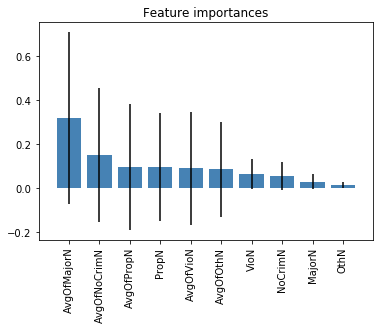

In [150]:
featureImportancePlot(rf, features)

**Comment: In this model, avaerage of major crimes is the most predictive feature while the number of other crimes is the least predictive feature in this model.**

# 11. Random forest with crime and medical features

## 11.1 Create a random forest model that only uses the 3 most predictive features about school crimes and the health features 

In [152]:
std1 = pd.DataFrame(columns=alldata.columns, data=preprocessing.scale(alldata))
std1.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
0,-1.555123,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.108271,-1.025939,0.396053,0.240826
1,-1.541252,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757,-0.247943,-0.165577,0.431142,-0.287559
2,-1.534316,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402,-1.129957,-1.080542,0.888153,2.616807
3,-1.520445,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.405819,-1.474018,1.542707,-0.605590
4,-1.506573,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.246679,-1.291914,1.705806,-0.774296


In [153]:
std1.rename(columns={"Major N":"MajorN","Oth N":"OthN","NoCrim N":"NoCrimN","Prop N":"PropN",
                     "Vio N":"VioN","AvgOfMajor N":"AvgOfMajorN","AvgOfOth N":"AvgOfOthN",
                     "AvgOfNoCrim N":"AvgOfNoCrimN","AvgOfProp N":"AvgOfPropN","AvgOfVio N":"AvgOfVioN"},
            inplace=True)

**I'll choose avaerage of major crimes(AvgOfMajorN), average of non-criminal crimes(AvgOfNoCrimN) and average of violent crimes(AvgOfVioN) since these three features are 3 most predictive features according to the feature importance test above.**

In [186]:
rfdf = std1[['AvgOfMajorN','AvgOfNoCrimN','AvgOfPropN', 'SATall','asthmaRatio','drugsRatio']]
rfdf.head()

,AvgOfMajorN,AvgOfNoCrimN,AvgOfPropN,SATall,asthmaRatio,drugsRatio
0,-0.923409,-0.765379,-0.852250,-1.025939,0.396053,0.240826
1,-0.617695,-0.577461,-0.575915,-0.165577,0.431142,-0.287559
2,-0.576952,-0.551243,-0.547694,-1.080542,0.888153,2.616807
3,-0.923409,-0.765379,-0.852250,-1.474018,1.542707,-0.605590
4,-0.923409,-0.765379,-0.852250,-1.291914,1.705806,-0.774296


In [203]:
# Labels are the values we want to predict
label1 = np.array(rfdf['SATall'])
# Remove the labels from the features
feature1 = rfdf.drop('SATall', axis = 1)
# Saving feature names for later use
feature_list1 = list(feature1.columns)
# Convert to numpy array
feature1 = np.array(feature1)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
     feature1,label1, test_size=0.33, random_state=42, shuffle=True)

In [205]:
rf1 = rfr()
rf1.fit(X_train, y_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [206]:
y_pred = rf1.predict(X_test)

## 11.2 Evaluate the performance of the model (3 points)

In [207]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.49 degrees.


In [208]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 59.21 %.


In [209]:
rtrain = rf1.score(X_train, y_train)
print('R-sqaured of train model:', round(np.mean(rtrain), 2))

R-sqaured of train model: 0.87


In [210]:
rtest = rf1.score(X_test, y_test)
print('R-sqaured of test model:', round(np.mean(rtest), 2))

R-sqaured of test model: 0.38


**Comment: This model has 59.21% accuracy on prediction. The R-sqaured of training set is 0.87 while the R-squared of test set is 0.38. The overfitting problem still occured, but not serious as the above model(random forest regression model which only has school crimes features). The reason why the overfitting problem in this model is not severe than the previous model is because I only choose three crime features that has higher predictive ability, and the medical features are not correlated so the collinearity between independent variables are addressed in certain level.**

## 11.3 Discuss the importance of each feature in the model 

In [211]:
features = feature_list1

In [212]:
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(len(rf1.feature_importances_)):
    print("%d. feature  %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature  AvgOfMajorN (0.359141)
2. feature  asthmaRatio (0.295650)
3. feature  AvgOfNoCrimN (0.151726)
4. feature  drugsRatio (0.112591)
5. feature  AvgOfPropN (0.080892)


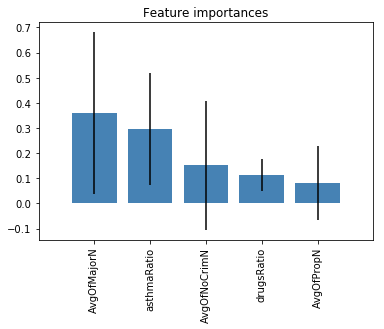

In [213]:
featureImportancePlot(rf1, features)

**Comment: In this model, average number of major crimes is the most predictive feature while average number of property crimes is the least predictive feature.**